# Section 5

In [1]:
using Plots
gr()
using LaTeXStrings

In [2]:
# Some utility
const newaxis = [CartesianIndex()] 

1-element Vector{CartesianIndex{0}}:
 CartesianIndex()

## Spectral function
Three Gaussians with parameters (position,width,weight) = (0,0.15,0.2),(±1,0.8,0.4).
The same spectrum was used in J. Otsuki et al., PRE 95, 061302(R) (2017).

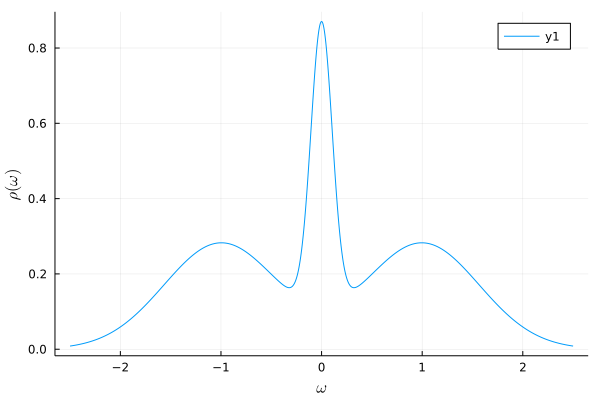

In [3]:
gaussian(x, mu, sigma) = exp(-((x-mu)/sigma)^2) / (sqrt(π)*sigma)
rho(omega) = 0.2*gaussian(omega, 0.0, 0.15) + 0.4*gaussian(omega, 1.0, 0.8) + 0.4*gaussian(omega, -1.0, 0.8)

omegas = range(-2.5, 2.5, length=1000)
plot(omegas, rho.(omegas), xlabel=latexstring("\\omega"), ylabel=latexstring("\\rho(\\omega)"))

## Imaginary-time Green's function

We transform the spectral function to the Green's function using
$$
G(\tau) = - \int_{-\omega_\mathrm{max}}^{\omega_\mathrm{max}}d\tau K(\tau, \omega) \rho(\omega),
$$
where
$$
K(\tau, \omega) = \frac{e^{-\tau\omega}}{1+e^{-\beta\omega}}.
$$

When we discretize the kernel on uniform meshs for $\tau$ and $\omega$,
we obtain
$$
G(\tau_i) = - \frac{2\omega_\mathrm{max}}{N_\omega} \sum_j K(\tau_i, \omega_j) \rho(\omega_j) 
$$
for $i=1,2,\cdots,N_\tau$ and $j=1,2,\cdots,N_\omega$.
The cut-off frequency $\omega_\mathrm{max}$ must be large enough.
In this example, we use $\omega_\mathrm{max}=10$.

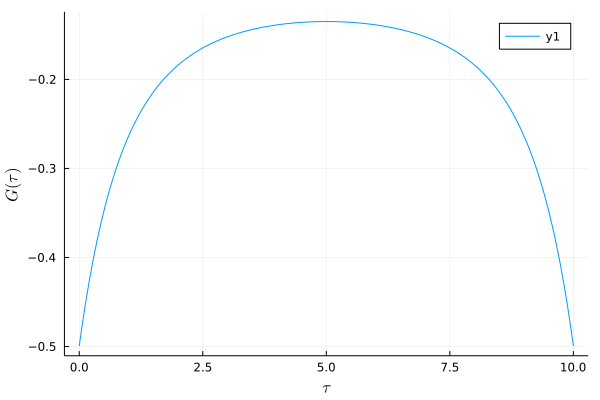

In [4]:
wmax = 10.0
beta = 10.0

nomega = 1000
ntau = 1000

omegas_mesh = collect(range(-wmax, wmax, length=nomega))
taus_mesh = collect(range(0, beta, length=ntau))

kernel(tau, omega) = exp(-tau*omega)/(1 + exp(-beta*omega))

kernel_val = kernel.(taus_mesh[:,newaxis], omegas_mesh[newaxis,:])
gtau = - kernel_val * rho.(omegas_mesh) * (2*wmax/nomega)

plot(taus_mesh, gtau, xlabel=latexstring("\\tau"), ylabel=latexstring("G(\\tau)"))

In [5]:
print(gtau[1])

-0.4995

## Reconstruction of spectral function

Can we reconstruct the original $\rho(\omega)$?
You might use
$$
\rho(\omega_j) = - \frac{N_\omega}{2\omega_\mathrm{max}} \sum_i (K^{-1})_{ji} G(\tau_j)
$$

.

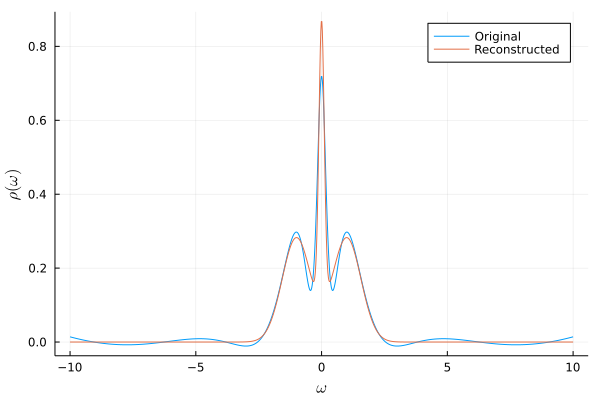

In [6]:
# OK, you get random data... (We actually used the pseudo inverse)
using LinearAlgebra

rho_reconst = -  (nomega/(2*wmax)) * (pinv(kernel_val, rtol=1e-3) * gtau)

plot(omegas_mesh, [rho_reconst, rho.(omegas_mesh)], labels=["Original" "Reconstructed"], xlabel=latexstring("\\omega"), ylabel=latexstring("\\rho(\\omega)"))

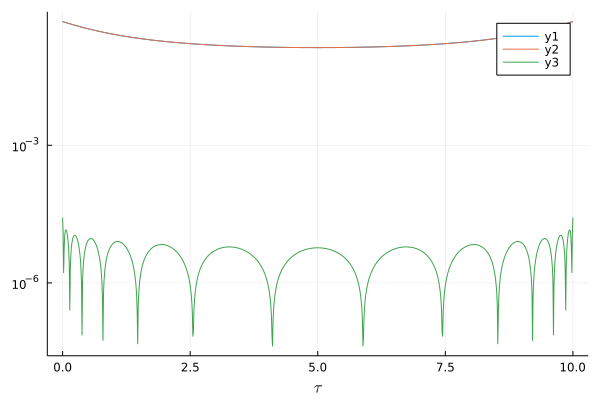

In [7]:
gtau_reconst = - (kernel_val * rho_reconst) * (2*wmax/nomega)
plot(taus_mesh, [-gtau, -gtau_reconst, abs.(gtau-gtau_reconst)], yaxis=:log, xlabel=latexstring("\\tau"))

## Singular values

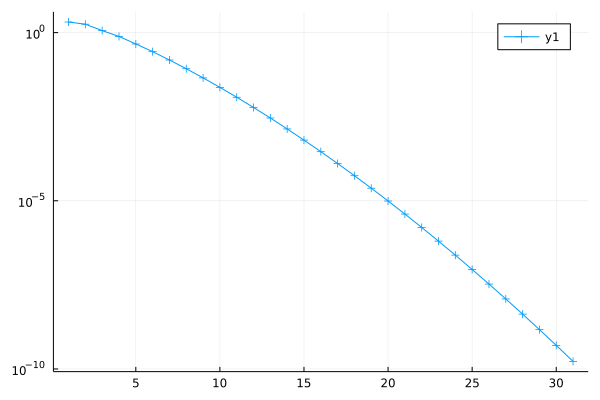

In [8]:
K = kernel_val * (2*wmax/nomega)
F = svd(K)
u, s, vh = F.U, F.S, F.Vt 
plot(s[1:31], marker=:cross, yaxis=:log)

## Singular vectors

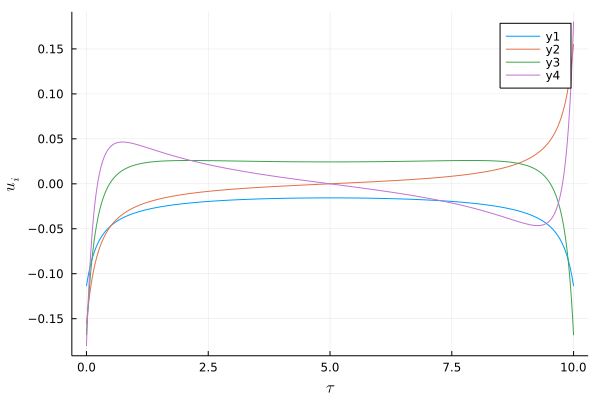

In [9]:
plot(taus_mesh, u[:,1:4], xlabel=latexstring("\\tau"), ylabel=latexstring("u_i"))

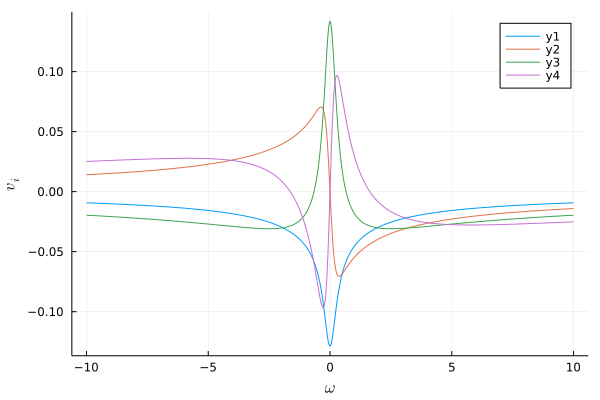

In [10]:
plot(omegas_mesh, transpose(vh[1:4,:]), xlabel=latexstring("\\omega"), ylabel=latexstring("v_i"))

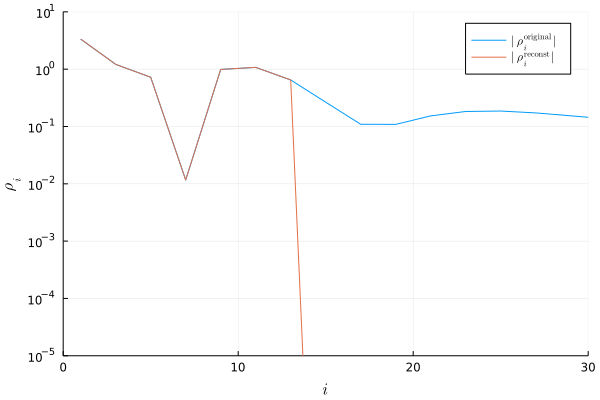

In [11]:
rhoi = vh * rho.(omegas_mesh)
rhoi_reconst = vh * rho_reconst
gi = transpose(u) * gtau
gi_reconst = transpose(u) * gtau_reconst

x = collect(1:length(rhoi))
plot(
    x[1:2:end],  [abs.(rhoi)[1:2:end], abs.(rhoi_reconst)[1:2:end]], xlims=(0,30), yaxis=:log, ylim=(1e-5,10),
    xlabel=latexstring("i"), ylabel=latexstring("\\rho_i"),
    labels=[latexstring("|\\rho^\\mathrm{original}_i|") latexstring("|\\rho^\\mathrm{reconst}_i|")]
    )

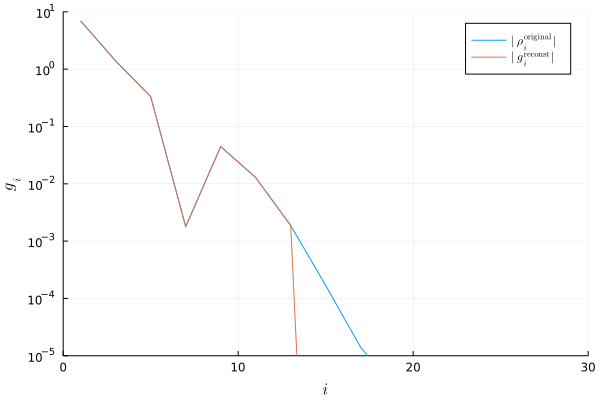

┌ Warning: Invalid negative or zero value 0.0 found at series index 87 for log10 based yscale
└ @ Plots /Users/hiroshi/.julia/packages/Plots/1KWPG/src/utils.jl:95
┌ Warning: Invalid negative or zero value 0.0 found at series index 28 for log10 based yscale
└ @ Plots /Users/hiroshi/.julia/packages/Plots/1KWPG/src/utils.jl:95
┌ Warning: Invalid negative or zero value 0.0 found at series index 87 for log10 based yscale
└ @ Plots /Users/hiroshi/.julia/packages/Plots/1KWPG/src/utils.jl:95
┌ Warning: Invalid negative or zero value 0.0 found at series index 28 for log10 based yscale
└ @ Plots /Users/hiroshi/.julia/packages/Plots/1KWPG/src/utils.jl:95
┌ Warning: Invalid negative or zero value 0.0 found at series index 87 for log10 based yscale
└ @ Plots /Users/hiroshi/.julia/packages/Plots/1KWPG/src/utils.jl:95
┌ Warning: Invalid negative or zero value 0.0 found at series index 28 for log10 based yscale
└ @ Plots /Users/hiroshi/.julia/packages/Plots/1KWPG/src/utils.jl:95


In [12]:
plot(
    x[1:2:end],  [abs.(gi)[1:2:end], abs.(gi_reconst)[1:2:end]], xlims=(0,30), yaxis=:log, ylim=(1e-5,10),
    xlabel=latexstring("i"), ylabel=latexstring("g_i"),
    labels=[latexstring("|\\rho^\\mathrm{original}_i|") latexstring("|g^\\mathrm{reconst}_i|")]
    )

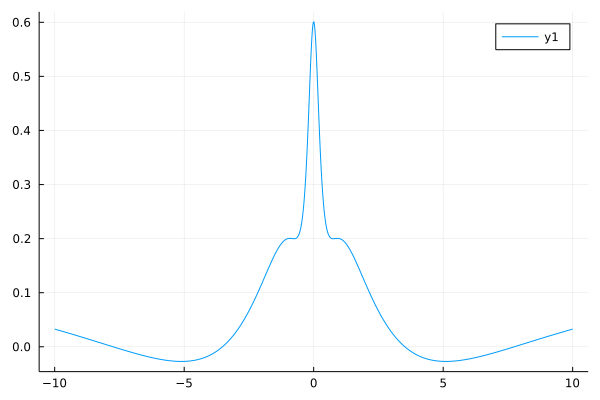

In [13]:
num_comp = 10
plot(omegas_mesh, vec(rhoi[newaxis,1:num_comp]*vh[1:num_comp,:]))